## Noisy simulator with error mitigation

This is the notebook for noisy simulation. You are recommended to check this [notebook](HA_noiseless_qiskit.ipynb) first before starting with this one.

In [1]:
import numpy as np
import math
from math import pi
import matplotlib.pyplot as plt
# magic word for producing visualizations in notebook
%matplotlib inline

from scipy.special import iv
from scipy.linalg import expm, block_diag
from scipy import integrate
from openfermion import fermi_hubbard, jordan_wigner, get_sparse_operator
from collections import Counter

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer, transpile
from qiskit.circuit import Parameter
from qiskit.providers.fake_provider import FakeGuadalupe, FakeNairobi
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator, noise
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)

from HA_utils import get_fh_matrix, Assembly_ACDF, get_real_CDF

In [6]:
def fh_evolution_para(N_sites, theta_para, gamma_para, step, to_gate=True):
    
    qr = QuantumRegister(2*N_sites)
    qc = QuantumCircuit(qr)
    
    for _ in range(step):
        
        ## Hopping terms 
        #theta = tau*t*j/step
        #theta = Parameter('theta')
        
        for i in range(N_sites//2):
            qc.rxx(theta_para,2*i,2*i+1)
            qc.ryy(theta_para,2*i,2*i+1)

            qc.rxx(theta_para,2*i+N_sites,2*i+1+N_sites)
            qc.ryy(theta_para,2*i+N_sites,2*i+1+N_sites)
            
        for i in range((N_sites-1)//2):
            qc.rxx(theta_para,2*i+1,2*i+2)
            qc.ryy(theta_para,2*i+1,2*i+2)

            qc.rxx(theta_para,2*i+N_sites+1,2*i+2+N_sites)
            qc.ryy(theta_para,2*i+N_sites+1,2*i+2+N_sites)
        
        ## Potential
        #gamma = tau*j*U/(2*step)
        #gamma = Parameter('gamma')
        
        for i in range(N_sites):
            qc.rzz(gamma_para,i,i+N_sites)
    return qc.to_gate() if to_gate else qc

In [7]:
def initial_state_prep(N_sites, initial_state_symmetry=True, to_gate=True):

    qr = QuantumRegister(2*N_sites,'q')
    qc = QuantumCircuit(qr)

    if initial_state_symmetry:
        qc.h(0)
        for i in range(N_sites):
            if i%2!=0:
                qc.x(i)
            else:
                qc.x(i+N_sites)

        qc.cnot(0,range(1,2*N_sites))

    else:
        for i in range(N_sites):
            if i%2!=0:
                qc.x(i)
            else:
                qc.x(i+N_sites)
        

    return qc.to_gate() if to_gate else qc

In [9]:
def get_new_Hadamard_circuit_para(N_sites, theta_para, gamma_para, step, initial_state_symmetry=True,test_type='real'):

    qr = QuantumRegister(2*N_sites+2, 'q')
    qc = QuantumCircuit(qr)

    qc.h([0,1])
    if test_type=='real':
        pass
    elif test_type=='imag':
        qc.s(0)

    
    prep_gate = initial_state_prep(N_sites=N_sites,initial_state_symmetry=initial_state_symmetry)
    qc.append(prep_gate.control(), [0]+list(range(2,2*N_sites+2)))

    evolution_gate = fh_evolution_para(N_sites=N_sites, theta_para=theta_para, gamma_para=gamma_para, step=step)
    qc.append(evolution_gate,range(2,2*N_sites+2))

    prep_gate_conj = prep_gate.reverse_ops()
    qc.append(prep_gate_conj.control(), [1]+list(range(2,2*N_sites+2)))

    qc.h([0,1])

    qc.measure_all()

    
    return qc 

`prqs` is the function to random compiling the CNOT gates with single Pauli gates. This random compiling can help us turn coherent noise into depolarizing noise, which is easy to mitigate through error extrapolation.

In [11]:
def prqs(random_number, extra_level): 
    
    extra_level = 2 * extra_level + 1
    qc = QuantumCircuit(2)
    pqrs_list = ['IIII','IXIX','IYZY','IZZZ','YIYX','YXYI','YYXZ','YZXY','XIXX','XXXI','XYYZ','XZYY','ZIZI','ZXZX','ZYIY','ZZIZ']
    if random_number == 0:
        qc.i(0)
        qc.i(1)
        for i in range(extra_level):
            qc.cnot(0,1)
        qc.i(0)
        qc.i(1)
    elif random_number == 1:
        qc.i(0)
        qc.x(1)
        for i in range(extra_level):
            qc.cnot(0,1)
        qc.i(0)
        qc.x(1)
    elif random_number == 2:
        qc.i(0)
        qc.y(1)
        for i in range(extra_level):
            qc.cnot(0,1)
        qc.z(0)
        qc.y(1)
    elif random_number == 3:
        qc.i(0)
        qc.z(1)
        for i in range(extra_level):
            qc.cnot(0,1)
        qc.z(0)
        qc.z(1)     
    elif random_number == 4:
        qc.y(0)
        qc.i(1)
        for i in range(extra_level):
            qc.cnot(0,1)
        qc.y(0)
        qc.x(1)   
    elif random_number == 5:
        qc.y(0)
        qc.x(1)
        for i in range(extra_level):
            qc.cnot(0,1)
        qc.y(0)
        qc.i(1)
    elif random_number == 6:
        qc.y(0)
        qc.y(1)
        for i in range(extra_level):
            qc.cnot(0,1)
        qc.x(0)
        qc.z(1)
    elif random_number == 7:
        qc.y(0)
        qc.z(1)
        for i in range(extra_level):
            qc.cnot(0,1)
        qc.x(0)
        qc.y(1)
    elif random_number == 8:
        qc.x(0)
        qc.i(1)
        for i in range(extra_level):
            qc.cnot(0,1)
        qc.x(0)
        qc.x(1)
    elif random_number == 9:
        qc.x(0)
        qc.x(1)
        for i in range(extra_level):
            qc.cnot(0,1)
        qc.x(0)
        qc.i(1)     
    elif random_number == 10:
        qc.x(0)
        qc.y(1)
        for i in range(extra_level):
            qc.cnot(0,1)
        qc.y(0)
        qc.z(1)   
    elif random_number == 11:
        qc.x(0)
        qc.z(1)
        for i in range(extra_level):
            qc.cnot(0,1)
        qc.y(0)
        qc.y(1)
    elif random_number == 12:
        qc.z(0)
        qc.i(1)
        for i in range(extra_level):
            qc.cnot(0,1)
        qc.z(0)
        qc.i(1)
    elif random_number == 13:
        qc.z(0)
        qc.x(1)
        for i in range(extra_level):
            qc.cnot(0,1)
        qc.z(0)
        qc.x(1)
    elif random_number == 14:
        qc.z(0)
        qc.y(1)
        for i in range(extra_level):
            qc.cnot(0,1)
        qc.i(0)
        qc.y(1)
    elif random_number == 15:
        qc.z(0)
        qc.z(1)
        for i in range(extra_level):
            qc.cnot(0,1)
        qc.i(0)
        qc.z(1)
    return qc

`error_mitigation` take an ideal circuit as input, and return you the random compiled circuit with each CNOT gate replaced by multiple CNOT gates. These different circuit will be used for error extrapolation.

In [12]:
def error_mitigation(N_sites, trans_qc, extra_level):  #extra_level startz from 0. cnot_num = 2 * extra_level + 1
    
    num_qubits = trans_qc.num_qubits
    qc = QuantumCircuit(num_qubits, 2 * N_sites + 2)

    me = 0
    for gate_data in trans_qc.data:
        gate = gate_data[0]
        qubits = gate_data[1]
        if gate.name == 'cx':
            index = [qubits[0].index, qubits[1].index]
            random_num = np.random.randint(16)
            qc.append(prqs(random_num, extra_level), index) # random compiling with the 'random_num'-th random set and '2*extra_level' CNOTs
        elif gate.name == 'measure':
            qc.measure(qubits[0], [me])
            me = me + 1

        else:
            qc.append(gate_data)
    
    return qc

In [13]:
def get_shots_per_run(F_list, total_shots,type='sample'):

    F_list_abs = np.array([np.abs(ele) for ele in F_list])
    probs = F_list_abs/sum(F_list_abs)
    if type=='sample':

        sampling = np.random.choice(range(len(probs)), size=int(total_shots), p=probs)
        counter = Counter(sampling)
        shots_list = np.zeros(len(probs),dtype=int)
        for i in range(len(probs)):
            shots_list[i] = int(counter[i])
    elif type =='distribution':
        shots_list = np.round(total_shots*probs)
        
    return shots_list

In [67]:
def get_circuit_list_to_run(N_sites,t,U,tau,step,shots_list,backend,extra_level,initial_state_symmetry=True):

    circ_list_real = []
    circ_list_imag = []
    theta = Parameter('theta')
    gamma = Parameter('gamma')
    circ_para_real = get_new_Hadamard_circuit_para(N_sites,theta_para=theta, gamma_para=gamma, step=step, initial_state_symmetry=initial_state_symmetry,test_type='real')
    circ_para_imag = get_new_Hadamard_circuit_para(N_sites,theta_para=theta, gamma_para=gamma, step=step, initial_state_symmetry=initial_state_symmetry,test_type='imag')

    circ_transpiled_real = transpile(circuits=circ_para_real, backend=backend, basis_gates=['cx','u3'], optimization_level=3)
    circ_transpiled_imag = transpile(circuits=circ_para_imag, backend=backend, basis_gates=['cx','u3'], optimization_level=3)

    circ_mitigated_real = error_mitigation(N_sites, circ_transpiled_real, extra_level=extra_level).decompose()
    circ_mitigated_imag = error_mitigation(N_sites, circ_transpiled_imag, extra_level=extra_level).decompose()

    # circ_transpiled_mitigated_real = transpile(circuits=circ_mitigated_real, backend=backend, optimization_level=0)
    # circ_transpiled_mitigated_imag = transpile(circuits=circ_mitigated_imag, backend=backend, optimization_level=0)
    
    circ_transpiled_mitigated_real = circ_mitigated_real
    circ_transpiled_mitigated_imag = circ_mitigated_imag
    
    for j, shot in enumerate(shots_list):

        if shot:
            
            theta_value = tau*t*(2*j+1)/step
            gamma_value = tau*U*(2*j+1)/(2*step)
            circ_binded_real = circ_transpiled_mitigated_real.bind_parameters({theta:theta_value,gamma:gamma_value})
            circ_binded_real.name = 'Re-circ-'+str(j)
            circ_list_real.append(circ_binded_real)

            circ_binded_imag = circ_transpiled_mitigated_imag.bind_parameters({theta:theta_value,gamma:gamma_value})
            circ_binded_imag.name = 'Im-circ-'+str(j)
            circ_list_imag.append(circ_binded_imag)

    return circ_list_real, circ_list_imag

In [15]:
def get_new_Z_list(d, N_sites, t, U, tau, step, shots_list, backend, extra_level, initial_state_symmetry=True):
    
    extra = extra_level
    Z_list = np.zeros(d+1,dtype='complex')  

    circ_list_real,circ_list_imag = get_circuit_list_to_run(N_sites,t,U,tau,step,shots_list, backend, extra, initial_state_symmetry)
    
    index = 0
    for j in range(d+1):
        shots = shots_list[j]
        if shots != 0:  
            
            counts_real = backend.run(circ_list_real[index],shots=shots).result().get_counts()
            counts_imag = backend.run(circ_list_imag[index],shots=shots).result().get_counts()
            
            shots_real = counts_real.shots()
            shots_imag = counts_imag.shots()
            
            index = index + 1
            
            p00, p01, p10, p11 = 0,0,0,0
            if ('0'*2*N_sites+'00') in counts_real.keys():
                p00 = counts_real['0'*2*N_sites+'00']/shots_real
            if ('0'*2*N_sites+'01') in counts_real.keys():
                p01 = counts_real['0'*2*N_sites+'01']/shots_real
            if ('0'*2*N_sites+'10') in counts_real.keys():
                p10 = counts_real['0'*2*N_sites+'10']/shots_real
            if ('0'*2*N_sites+'11') in counts_real.keys():
                p11 = counts_real['0'*2*N_sites+'11']/shots_real

            X = p00+p11-p01-p10

            p00, p01, p10, p11 = 0,0,0,0
            if ('0'*2*N_sites+'00') in counts_imag.keys():
                p00 = counts_imag['0'*2*N_sites+'00']/shots_imag
            if ('0'*2*N_sites+'01') in counts_imag.keys():
                p01 = counts_imag['0'*2*N_sites+'01']/shots_imag
            if ('0'*2*N_sites+'10') in counts_imag.keys():
                p10 = counts_imag['0'*2*N_sites+'10']/shots_imag
            if ('0'*2*N_sites+'11') in counts_imag.keys():
                p11 = counts_imag['0'*2*N_sites+'11']/shots_imag

            Y = p00+p11-p01-p10

            lambda_R = U/4*N_sites

            Z = 2*(X-1j*Y)*np.exp(-1j*lambda_R*(2*j+1)*tau)
            Z_list[j] = Z

    return Z_list


In [1425]:
# ADD NOISE ON CNOTS

prob_2 = 0.0002  # 2-qubit gate
error_2 = noise.depolarizing_error(prob_2, 2)
noise_model = noise.NoiseModel()
noise_model.add_all_qubit_quantum_error(error_2, ['cx'])
backend = AerSimulator(noise_model=noise_model)

In [1271]:
# backend = Aer.get_backend('qasm_simulator')
d = 2000
N_sites,t,U,step = 4,1,4,2
initial_state_symmetry = True
# F_list_import = np.load('F_list_d2e4_lim1e4.npy')
F_list_import = np.load('F_list_d2e3_lim2e3_delta4.npy')
precision = 20000

shots_list = get_shots_per_run(F_list=F_list_import, total_shots=10000, type='distribution')

hubbard = fermi_hubbard(1, N_sites, t, U, periodic=False,particle_hole_symmetry=True)
jw_hamiltonian = jordan_wigner(hubbard)
jw_hamiltonian = jordan_wigner(hubbard)
fh_matrix = get_sparse_operator(jw_hamiltonian)
fh_matrix = fh_matrix.todense()
fh_matrix = fh_matrix.real

norm = np.linalg.norm(fh_matrix)
tau = 3*np.pi/(4*norm)

In [1272]:
%%time
extra_level = 0 # 2*0+1 cnot
Z_list_0 = get_new_Z_list(d, N_sites, t, U, tau, step, shots_list, backend, extra_level, initial_state_symmetry)
ACDF_0 = Assembly_ACDF(Z_list_0, F_list_import, precision)

C:\Users\1\AppData\Local\Temp\ipykernel_3456\1609993911.py:11: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  index = [qubits[0].index, qubits[1].index]


CPU times: total: 11min 10s
Wall time: 2min 14s


In [1273]:
%%time
extra_level = 1 # 2*1+1 cnot
Z_list_1 = get_new_Z_list(d, N_sites, t, U, tau, step, shots_list, backend, extra_level, initial_state_symmetry)
ACDF_1 = Assembly_ACDF(Z_list_1, F_list_import, precision)

C:\Users\1\AppData\Local\Temp\ipykernel_3456\1609993911.py:11: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  index = [qubits[0].index, qubits[1].index]


CPU times: total: 14min 48s
Wall time: 3min 1s


In [1274]:
%%time 
extra_level = 2 # 2*2+1 cnot
Z_list_2 = get_new_Z_list(d, N_sites, t, U, tau, step, shots_list, backend, extra_level, initial_state_symmetry)
ACDF_2 = Assembly_ACDF(Z_list_2, F_list_import, precision)

C:\Users\1\AppData\Local\Temp\ipykernel_3456\1609993911.py:11: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  index = [qubits[0].index, qubits[1].index]


CPU times: total: 18min 33s
Wall time: 3min 40s


In [1303]:
%%time 
extra_level = 3 # 2*3+1 cnot
Z_list_3 = get_new_Z_list(d, N_sites, t, U, tau, step, shots_list, backend, extra_level, initial_state_symmetry)
ACDF_3 = Assembly_ACDF(Z_list_3, F_list_import, precision)

C:\Users\1\AppData\Local\Temp\ipykernel_3456\1609993911.py:11: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  index = [qubits[0].index, qubits[1].index]


CPU times: total: 22min 6s
Wall time: 4min 12s


In [1278]:
CDF = get_real_CDF(N_sites,t,U, tau, precision, initial_state_symmetry)

E:\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
E:\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
E:\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
E:\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 1.0, 'N_sites=4; CNOT gate error = 0.0002')

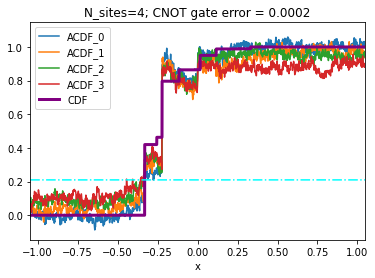

In [1417]:
half_nsites_4 = 0.41990430810024304*1/2
plt.plot(np.linspace(-pi,pi,precision), ACDF_0, label='ACDF_0')
plt.plot(np.linspace(-pi,pi,precision), ACDF_1, label='ACDF_1')
plt.plot(np.linspace(-pi,pi,precision), ACDF_2, label='ACDF_2')
plt.plot(np.linspace(-pi,pi,precision), ACDF_3, label='ACDF_3')
plt.plot(np.linspace(-np.pi/3, np.pi/3, precision), CDF, label='CDF',c='purple', linewidth=3)
plt.legend()
plt.plot(np.linspace(-np.pi/3, np.pi/3, precision), half_nsites_4 * np.ones(precision), linestyle='-.', c='cyan')
plt.xlim([-pi/3, pi/3])
plt.xlabel('x')
plt.title('N_sites=4; CNOT gate error = 0.0002')
# plt.xlim([-0.37,-0.35])

In [1355]:
def result_from_ACDF(start_point, ACDF, range_):  # Retrieve the eresult from ACDF
    for i in range(7000, int(precision/2)):
        if ACDF[i] <= half_nsites_4 and ACDF[i+1] >= half_nsites_4 and np.linspace(-np.pi, np.pi, precision)[i]>=range_:
            result = 1/2*(np.linspace(-np.pi, np.pi, precision)[i] + np.linspace(-np.pi, np.pi, precision)[i+1])
            break
    return result

range_ = -0.36    # Estimated minimum leaping point 
index = 6836

## Find result from ACDF_0

In [1356]:
result_0 = result_from_ACDF(7000, ACDF_0, range_)
print(result_0)

-0.3323971226059306


## Find result from ACDF_1

In [1357]:
result_1 = result_from_ACDF(7000, ACDF_1, range_)
print(result_1)

-0.3339679974764691


## Find result from ACDF_2

In [1358]:
result_2 = result_from_ACDF(7000, ACDF_2,range_)
print(result_2)

-0.34653499644077645


## Find result from ACDF_3

In [1359]:
result_3 = result_from_ACDF(7000, ACDF_3,range_)
print(result_3)

-0.3572169455604377


In [5]:
from scipy.optimize import curve_fit
error_weight = np.array([1,3,5,7])
# final = np.array([result_0, result_1, result_2, result_3])
final = np.array([-0.3323971226059306,-0.3339679974764691,-0.34653499644077645,-0.3572169455604377])

## Error Mitigation Poly

mitigated_value = -0.3313878355016092
standard_value = -0.33135


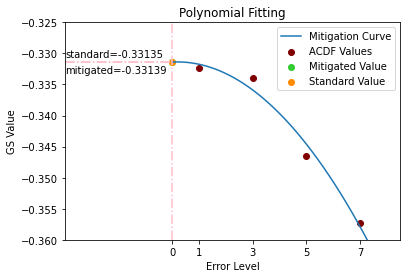

In [36]:
# Curve Fitting
coeff = np.polyfit(error_weight, final, 2)

def func_poly(x, a, b, c):
    return a*x**2 + b*x + c

x_fit = np.linspace(0,8,100)
plt.plot(x_fit, func_poly(x_fit, *coeff), label='Mitigation Curve')
mitigated_value = func_poly(0, *coeff)

plt.scatter(error_weight, final, c='maroon', label='ACDF Values')


# standard_value = 1/2*(np.linspace(-np.pi/3, np.pi/3, precision)[index-1]+np.linspace(-np.pi/3, np.pi/3, precision)[index])
standard_value = -0.33135
print(f'mitigated_value =', mitigated_value)
print(f'standard_value =', standard_value)

plt.scatter(0, mitigated_value, c='limegreen',label='Mitigated Value')
plt.scatter(0, standard_value, c='darkorange',label='Standard Value')

plt.xlim([-4,8.5])
plt.ylim([-0.360,-0.325])
plt.legend()
plt.plot(np.zeros(10), np.linspace(-0.360,-0.325,10), c = 'pink', linestyle='-.')
plt.plot(np.linspace(-4,0,10), np.ones(10) * mitigated_value, c = 'pink', linestyle='-.')
plt.plot(np.linspace(-4,0,10), np.ones(10) * standard_value, c = 'pink', linestyle='-.')

# from matplotlib.pyplot import MultipleLocator
# x_major_locator = MultipleLocator(2)
# ax = plt.gca()
# ax.xaxis.set_major_locator(x_major_locator)
plt.xticks([0,1,3,5,7])

plt.text(-4,mitigated_value-0.0018, s = 'mitigated=-0.33139')
plt.text(-4,standard_value+0.0008, s = 'standard=-0.33135')
plt.xlabel('Error Level')
plt.ylabel('GS Value')
plt.title('Polynomial Fitting')
plt.show()

## Error Mitigation Expo

mitigated_value = -0.3319099999999999
standard_value = -0.33135


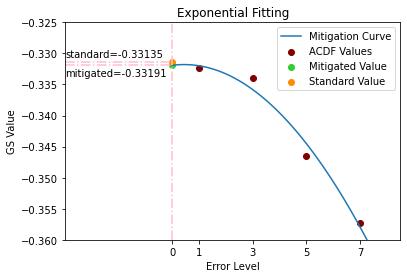

In [38]:
# Curve Fitting

# Import from MATLAB CURVE FITTING APP
def func_expo(x):
    b =    0.0006133  
    c =    0.0005289  
    d =      -1.33191  
    return np.exp(-b*x**2+c*x)+d
# Import from MATLAB CURVE FITTING APP


x_fit = np.linspace(0,8,100)
plt.plot(x_fit, func_expo(x_fit), label='Mitigation Curve')
mitigated_value = func_expo(0)



plt.scatter(error_weight, final, c='maroon', label='ACDF Values')



# standard_value = 1/2*(np.linspace(-np.pi/3, np.pi/3, precision)[index-1]+np.linspace(-np.pi/3, np.pi/3, precision)[index])
standard_value = -0.33135
print(f'mitigated_value =', mitigated_value)
print(f'standard_value =', standard_value)

plt.scatter(0, mitigated_value, c='limegreen',label='Mitigated Value')
plt.scatter(0, standard_value, c='darkorange',label='Standard Value')

plt.xlim([-4,8.5])
plt.ylim([-0.360,-0.325])
plt.legend()
plt.plot(np.zeros(10), np.linspace(-0.360,-0.325,10), c = 'pink', linestyle='-.')
plt.plot(np.linspace(-4,0,10), np.ones(10) * mitigated_value, c = 'pink', linestyle='-.')
plt.plot(np.linspace(-4,0,10), np.ones(10) * standard_value, c = 'pink', linestyle='-.')

# from matplotlib.pyplot import MultipleLocator
# x_major_locator = MultipleLocator(2)
# ax = plt.gca()
# ax.xaxis.set_major_locator(x_major_locator)
plt.xticks([0,1,3,5,7])

plt.xlabel('Error Level')
plt.ylabel('GS Value')
plt.text(-4,mitigated_value-0.0018, s = 'mitigated=-0.33191')
plt.text(-4,standard_value+0.0008, s = 'standard=-0.33135')
plt.title('Exponential Fitting')
plt.show()